# Introduction
Image classification is the process of taking an input (like a picture) and outputting a class (like “cat”) or a probability that the input is a particular class (“there’s a 90% probability that this input is a cat”). You can look at a picture and know that you’re looking at a terrible shot of your own face, but how can a computer learn to do that? With a convolutional neural network!

-----
# Goals
We would like you to establish a neural network involving advance DNN modules (i.e. convolution layers, RELU, pooling and fully connection layers and etc.)  to distinguish the specific category of an input image.

-------------
## Packages
Let's first import the necessary packages,

In [1]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import os

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'

-----
## Configuration
### hyper parameters
We then set up and hyper parameters that need for the our model.
we need to define several hyper parameters for our model:
1. learning rate
2. batch size when training
3. batch size when testing
4. numbper of epoches
5. out put directory

In [3]:
learningRate = 0.001
trainBatchSize = 100
testBatchSize = 100
epoches = 50
filename = "./output"

Create a directory if not exists
using os.path.exists() to check whether it is exist
using os.makedires to create a directory.

In [4]:
if not os.path.exists(filename):
    os.makedirs(filename)

-----
##  Data Loading
Next, we are going to load our data. 
### We need to prepare our data:

### We first import necessary librarys for data loading

In [5]:
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data
from ipywidgets import IntProgress
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

# Requirement 1

-----
###  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use .RandomHorizontalFlip()
3. You add any extra transforms you like.
4. Create this transform for both training set and testting set. Note that the testing spilit do not require any transform

In [6]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

-----
### We then download and prepare the data with the transforms defined above:
1. Use command torchvision.datasets.CIFAR10() with root, train, download and transform posional arguments.
2. Use the same command to create both train split and test split.
3. Use torch.utils.data.DataLoader() to create the data loader based on the data we have.
3. Use this command for both training split data loader and test split data loader

In [7]:
train_set = dset.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=trainBatchSize, shuffle=True)
test_set = dset.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=testBatchSize, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Requirement 2

-----
##  Network
Next, we are going to design our GoogLeNet
### First, we define our GoogLeNet class
### You need to refer the paepr below to understand the structure.
### https://arxiv.org/abs/1409.4842


<img src="./a.png" height="200" width="600">



<img src="./b.png" height="200" width="600">

------
### Inception Module with dimension reductions (There exist many implement methods)
1. Create a python class called Inception which inherits nn.module

2. Create a init function to init this python class
    1. Require in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x and pool_planes 7 arguments.
    
    2. Consists of 4 variables b1,b2,b3,b4
    
    3. b1 is a block consists of 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
    4. b2 is a block consists of tow 2D convaluations, two 2D batch normalization layers and tow ReLU activation functions
    
    5. b3 is a block consists of three 2D convaluations, three 2D batch normalization layers and three ReLU activation functions
    
    6. b4 is a block consists of a Maxpooling layer, a 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the concatenation of all the output.

In [8]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        #b1 is a block consists of 2D convaluation, a 2D batch normalization layer and a ReLU activation function
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        #b2 is a block consists of two 2D convaluations, two 2D batch normalization layers and tow ReLU activation functions
        self.b2 = nn.Sequential(
            #1
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            #2
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True))


        # 1x1 conv -> 5x5 conv branch
        #b3 is a block consists of three 2D convaluations, three 2D batch normalization layers and three ReLU activation functions
        #self.b3 = nn.Sequential(
        self.b3 = nn.Sequential(
            #1
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            #2
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            #3
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True))
         

        # 3x3 pool -> 1x1 conv branch
        #b4 is a block consists of a Maxpooling layer, a 2D convaluation, a 2D batch normalization layer and a ReLU activation function
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True))
       
    #this forward function will forward the input function though every block and return the concatenation of all the output.
    def forward(self, x):
        b1_output, b2_output, b3_output, b4_output  = self.b1(x), self.b2(x), self.b3(x) , self.b4(x)
        AllOutputConcatenation= torch.cat([b1_output,b2_output,b3_output,b4_output], 1)
        return AllOutputConcatenation


-----
### GoogLeNet Module (There exist many implement methods)

<img src="./Picture1.png" height="1000" width="10000">


1. Create a python class called GoogLeNet which inherits nn.module

2. Create a init function to init this python class

    1. Consists of a variables that serves as all layers before the inception, which contains a 2D convaluation with padding=1, kernel_size=3 output channel=192, a 2D batch normalization layer and a ReLU activation fucntion.
    
    3. Two Inception block
    
    4. Maxpooling layer
    
    5. Seven Inception block
    
    6. Average Pooling layer
    
    7. A fully connected layer.
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the output

In [9]:
class GoogLeNet(nn.Module):

    def __init__(self):
        super(GoogLeNet, self).__init__()
        #Consists of a variables that serves as all layers before the inception, 
        #which contains a 2D convaluation with padding=1, kernel_size=3 output channel=192, 
        #a 2D batch normalization layer and a ReLU activation fucntion.
        self.preinc = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True))
        #Two Inception block
        self.inc1 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.inc2 = Inception(256, 128, 128, 192, 32, 96, 64)
        #Maxpooling layer
        self.mp = nn.MaxPool2d(3, stride=2, padding=1)
        #Seven Inception block
        self.inc3 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.inc4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.inc5 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.inc6 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.inc7 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.inc8 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inc9 = Inception(832, 384, 192, 384, 48, 128, 128)
        #Average Pooling layer
        self.ap = nn.AvgPool2d(8, stride=1)
        #Fully Connected Layer
        self.fully_connected_layer  = nn.Linear(1024,10)

    #this forward function will forward the input function though every block and return the output
    def forward(self,x):
        x = self.preinc(x)
        x = self.inc1(x)
        x = self.inc2(x)
        x = self.mp(x)
        x = self.inc3(x)
        x = self.inc4(x)
        x = self.inc5(x)
        x = self.inc6(x)
        x = self.inc7(x)
        x = self.mp(x)
        x = self.inc8(x)
        x = self.inc9(x)
        x = self.ap(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected_layer(x)

        return x

### Next, we create the networka and send it to the target device

In [10]:
goNetwork = GoogLeNet()
goNetwork.to(device)

GoogLeNet(
  (preinc): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (inc1): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, mom

### Finally, We create:
 1. an optimizer  (we use adam optimzer here)
 2. A Criterion (CrossEntropy) function
 3. A Scheduler which is used to decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

In [11]:
# an optimizer (we use adam optimzer here)
optimizer = torch.optim.Adam(goNetwork.parameters(), lr=learningRate)
#A Criterion (CrossEntropy) function
criterion = nn.CrossEntropyLoss()
# A Scheduler which is used to decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)


# Requirement 3 and 4

-----
##  Training
Then, we are going to train our Network

1. Set our network to the training model.
2. Init the train loss, total data and number corrected predictions. 
3. For each data in the training split
    1. Put the data to the correct devices using .to()
    2. Reset the gradient of the optimzier.
    3. Feed the data forward to the google net
    4. Use the criterion function to compute the loss term
    5. Backprop the loss
    6. Update the network parameters using the optimzier
    7. Accumulate the training loss
    8. Find the prediciton. hint: using torch.max()
    9. Increment the data size
    10. Increment the corrected prediction
    11. Print log

    
-----
##  Testing
Then, we are going to test our module

1. Set our network to the test model.
2. Init the test loss, total data and number corrected predictions. 
3. For each data in the training split, we warp it using torch.no_grad()
    1. Put the data to the correct devices using .to()
    2. Feed the data forward to the google net
    3. Use the criterion function to compute the loss term
    4. Accumulate the training loss
    5. Find the prediciton. hint: using torch.max()
    6. Increment the data size
    7. Increment the corrected prediction
    8. Print log

-----
##  Epochs:
For each epoch:
1. we first step our scheduler
2. we train our module
3. we test our module
4. we update the testing accuracy
5. we save the module at the end and print the accuracy

In [12]:
def TrainAndTest():
    #Set our network to the training model.
    goNetwork.train()
    #Init the train loss, total data and number corrected predictions.
    #Init the test loss, total data and number corrected predictions.
    trainLoss = 0
    dataTrain = 0
    cPredictionTrain = 0
    testLoss = 0
    dataTest = 0
    cPredictionTest = 0
#     For each data in the training split
    for j, (i, l) in enumerate(train_loader):
        #Put the data to the correct devices using .to()
        i = i.to(device)
        l = l.to(device)
        #Reset the gradient of the optimzier.
        optimizer.zero_grad()
        #Feed the data forward to the google net
        dataForward = goNetwork(i)
        #Use the criterion function to compute the loss term
        lossTerm = criterion(dataForward, l)
        # Backprop the loss
        lossTerm.backward()
        #Update the network parameters using the optimzier
        optimizer.step()
        #Accumulate the training loss
        trainLoss =trainLoss+ lossTerm.data
        #Find the prediciton. hint: using torch.max()
        temp, prediction = torch.max(dataForward.data,1)
        #Increment the data size
        ds=l.size(0)
        dataTrain =dataTrain+ ds
        #Increment the corrected prediction
        cPredictionTrain = cPredictionTrain+ (prediction == l).sum()
        
    #Set our network to the test model
    goNetwork.eval()
    #For each data in the testing split, we warp it using torch.no_grad()
    with torch.no_grad():            
        for j, (i, l) in enumerate(test_loader):
            # Put the data to the correct devices using .to()
            i = i.to(device)
            l = l.to(device)
            #Feed the data forward to the google net
            dataForward = goNetwork(i)
            # Use the criterion function to compute the loss term
            lossTerm = criterion(dataForward, l)
            #Accumulate the training loss
            testLoss =testLoss+ lossTerm.data
            #Find the prediciton. hint: using torch.max()
            temp, prediction = torch.max(dataForward.data,1)
            #Increment the data size
            ds=l.size(0)
            dataTest = dataTest+ds
            #Increment the corrected prediction
            cPredictionTest = cPredictionTest + (prediction == l).sum()
    
    return trainLoss, (cPredictionTrain/dataTrain)*100, testLoss, (cPredictionTest/dataTest)*100

In [13]:
AccuracyListTest, trainLossList, testLosslist, epochlists = [], [], [], []

for i in range(epoches):
    print("Epoch # {}".format(i))
    trainLoss, accTrain, testLoss, accTest =TrainAndTest()
    trainLossList.append(trainLoss)
    testLosslist.append(testLoss)
    print("       Train Accuracy {}, Test Accuracy {}, Train Loss {}, Test Loss {}".format(accTrain, accTest, trainLoss, testLoss))
    AccuracyListTest.append(accTest)
    epochlists.append(i)
    #at the last loop print the highest accuracy and save the module
    #updating the testing accuracy to the highest
    if i+1 == epoches:
        highestAcc= np.max(AccuracyListTest)
        highestAccIndex= AccuracyListTest.index(highestAcc) 
        print("===> BEST TEST ACC. PERFORMANCE: %.3f%% at Epoch: %.f" % (highestAcc,highestAccIndex))
        #Saving Latest Module checkpoint
        torch.save(goNetwork, './output/ModuleCheckpointSaved')
        #Module Checkpoint Saved Print Statement
        print("Module CheckPoint Saved")

Epoch # 0
       Train Accuracy 55.43000030517578, Test Accuracy 54.10000228881836, Train Loss 612.1132202148438, Test Loss 142.23353576660156
Epoch # 1
       Train Accuracy 73.3280029296875, Test Accuracy 72.94999694824219, Train Loss 377.0491638183594, Test Loss 77.69963836669922
Epoch # 2
       Train Accuracy 80.1199951171875, Test Accuracy 79.47999572753906, Train Loss 287.0626220703125, Test Loss 60.661075592041016
Epoch # 3
       Train Accuracy 83.67399597167969, Test Accuracy 76.7300033569336, Train Loss 234.84503173828125, Test Loss 72.923583984375
Epoch # 4
       Train Accuracy 86.1399917602539, Test Accuracy 84.29000091552734, Train Loss 200.8126678466797, Test Loss 45.535179138183594
Epoch # 5
       Train Accuracy 87.86399841308594, Test Accuracy 85.85999298095703, Train Loss 175.17205810546875, Test Loss 42.493595123291016
Epoch # 6
       Train Accuracy 89.41199493408203, Test Accuracy 82.1199951171875, Train Loss 152.4565887451172, Test Loss 53.951873779296875
Epoch 

# Requiment 5= Report

## Part  A: Program Explaining 

In this code we use the data set "CIFAR-10" in order to establish a neural network involving advance DNN modules. to distinguish thespecific category of an input image. In order to do so we went through few steps. 
    
1. Program a data loader for CIFAR-10 dataset:

    * In this part first we prepocess the images by making a preprocessing Objer using transform  compose and randomhorizental flop, this Object will be used by our data loader. Second we use data loader to download and load both trained and rest set. We simply split the data between training data and testing data. For this part we use pytorch to do so.
    

2. Built a CNN model for classification:

    * In this part we first start by making an Inception Class, in this inception class which inherits nn.module. We first create a init function to init this python class, and in the init function we would have 4 different blocks (b1,b2,b3, and b4). Each of those block would consists of numbers of 2D convaluation, a 2D batch normalization layer and a ReLU activation function. Then in this class function we create the forward function. In this input function we forward the input function though every block and return the concatenation of all the output.
    
    * In the second part of building the CNN model, we basiclly build a googlenet class, and in this googlenet class we use the inception class, and we pass the parameters shown in the picture above. This is consistedd of Two Inception block, Maxpooling layer, Seven Inception block, Average Pooling layer, A fully connected layer. Then we define another forward function which will forward the input function though every block and return the output.
    
3. For step three we create the networka and send it to the target device. 


4. For step four we write training and testing framworks in order to implement the classification to pipeline.
    * Train function: We use the train loader from step one, and then we train our network from step 3. First we put the data to the correct devices, reset the gradient of the optimzier, feed the data forward to the google net, use the criterion function to compute the loss term, Backprop the loss, Update the network parameters using the optimzier, accumulate the training loss, find the prediciton, increment the data size,increment the corrected prediction, and calculate the accuracy in the return. We return the train loss and the accuracy.
    * Test function: We use the test loader from step one, and then we test our module network from step 3. First we put the data to the correct devices, feed the data forward to the google net, use the criterion function to compute the loss term, accumulate the testing loss, find the prediciton, increment the data size,increment the corrected prediction, and calculate the accuracy in the return. We return the test loss and the accuracy.
    
5. For step 5 we run a for loop for epoches, we train and test the module we built using step four function. We print the accuracy and the loss for botht he train and the test data and save the data.




## Part B: Report Findings and Graph Loss Convergence

#### learningRate = 0.001, trainBatchSize = 100, testBatchSize = 100, and epoches = 50

1. Accuracy Findings
    * Test Accuracy: it increases as we move through the Epoches. Best Accuracies are found at the end and it improves towards the end. Best Accuracy recoreded is 91% 
    * Train Accuracy: it increases as we move through the Epoches. Best Accuracies are found at the end and it improves towards the end. Best Accuracy recoreded is 99% 
    * Test Loss:  it decreases as we move through the Epoches. Starts with 612 and go down to 9.
    * Train Loss: it decrease as we move throught the Epoches. Starts with 142 and go down to minimum of 43 towards the end.
    
Below is the graph of the loss covergence for both.


    


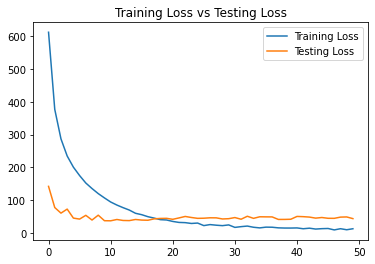

In [14]:
plt.title('Training Loss vs Testing Loss')
plt.plot(epochlists,trainLossList, label='Training Loss')
plt.plot(epochlists,testLosslist, label='Testing Loss')
plt.legend()
plt.show()